In [1]:
# Import necessary libraries
library(tidyverse)
library(readxl)
library(tidymodels)

# Set seed
set.seed(123)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Classification model for Taiwanese companies bankruptcy
## Introduction
Research and development as well as equity to liability are thought to be important factors in the success of an enterprise, but we were wondering how much it can predict its success. Our research question is as follows: by examining future growth investment through a company’s research and development expenditures, and its total equity growth, might one be able to form a reliable predictive model indicating whether or not it is likely to go bankrupt in the near future?

To answer this question, we have chosen a dataset titled “Taiwanese Bankruptcy Prediction”, compiled by the Taiwanese Economic Journal. This dataset includes quantitative data pertaining to 6819 companies along one main classifier: 0 for solvent, 1 for bankrupt. This data was gathered over a period of ten years from 1999 to 2009, and adds valuable insight to support that bankruptcy can be predicted ahead of time.

Out of 95 possible predictive variables, we chose to examine "Research and Development Expenses" and "Equity to Liability". We thought these were particularly interesting since they pertain to a company’s strategic approach towards future growth.

## Preliminary exploratory data analysis

In [2]:
# Read dataset into R
# For exploration we are selecting the data we are going to use because there are too many columns
# and renaming all of them here would get long.
download.file("https://raw.githubusercontent.com/GaryHilares/dsci100-2023w1-group00820/main/data.csv",
              "taiwanese_data.csv")
taiwanese_data <- read_csv("taiwanese_data.csv", col_names = FALSE, skip = 1) |>
                  select(X1, X13, X96) |>
                  mutate(X1 = as_factor(X1)) |>
                  rename(bankrupt = X1, development_expence_rate = X13, equity_to_liability = X96)
head(taiwanese_data)

Rows: 6819 Columns: 96
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (96): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


bankrupt,development_expence_rate,equity_to_liability
<fct>,<dbl>,<dbl>
1,0,0.01646874
1,0,0.02079431
1,25500000,0.01647411
1,0,0.02398233
1,0,0.03549020
1,0,0.01953448


In [3]:
# Summarize the amount of observations that we have per each label
taiwanese_data |> group_by(bankrupt) |> summarize(count = n())

bankrupt,count
<fct>,<int>
0,6599
1,220


In [4]:
# The label "bankrupt = 0" has much more representation than the other,
# and we have to many datapoints to visualize (if we do we will get overplotting)
# so we filter the data to make a smaller data set for exploration purposes.
taiwanese_bankrupt <- taiwanese_data |> filter(bankrupt == 1)
taiwanese_not_bankrupt <- taiwanese_data |> filter(bankrupt != 1)
taiwanese_not_bankrupt_small <- taiwanese_not_bankrupt |> sample_n(220)
taiwanese_small <- bind_rows(taiwanese_not_bankrupt_small, taiwanese_bankrupt)

In [5]:
# Split dataset into training and testing 
taiwanese_split <- initial_split(taiwanese_small, prop = 0.75, strata = bankrupt)
taiwanese_training <- training(taiwanese_split)
taiwanese_testing <- testing(taiwanese_split)

In [6]:
# Summarize how many row per each class there is.
taiwanese_training |> group_by(bankrupt) |> summarize(count = n())

# Missing data
## There is no missing data, as determined by manual inspection.

# Calculating the mean of each predictor
taiwanese_training |> summarize(DER_mean = mean(development_expence_rate),
                                ETL_mean = mean(equity_to_liability))

bankrupt,count
<fct>,<int>
0,165
1,165


DER_mean,ETL_mean
<dbl>,<dbl>
1433358788,0.03657082


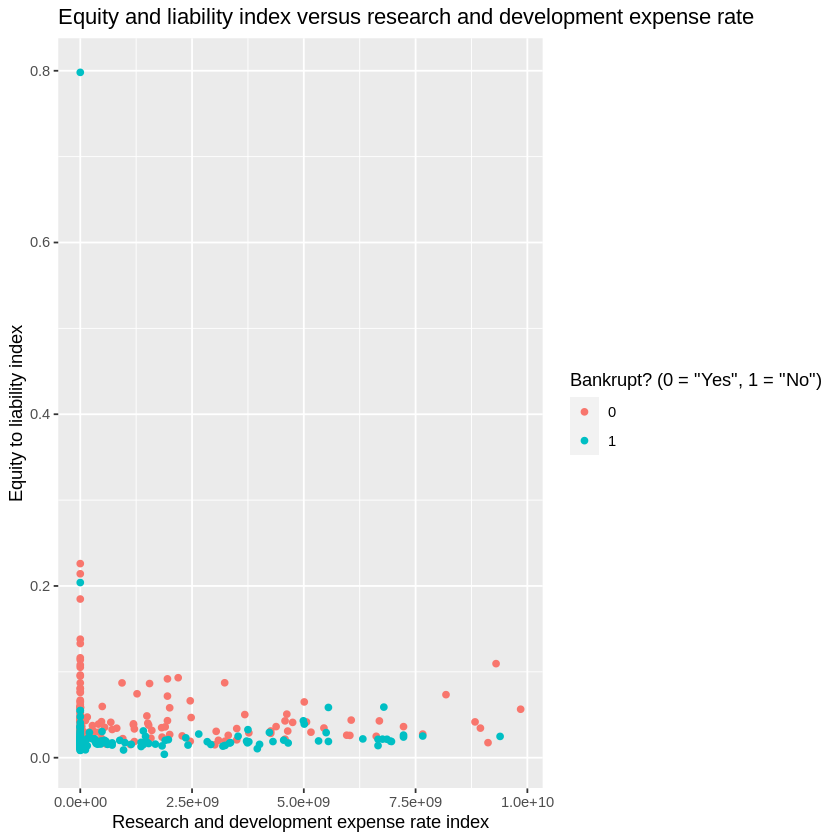

In [7]:
# Plot with predictor variables in the axes and colored points
taiwanese_training |> ggplot(aes(x = development_expence_rate, y = equity_to_liability, color = bankrupt)) +
                      geom_point() +
                      labs(title = "Equity and liability index versus research and development expense rate",
                           x = "Research and development expense rate index",
                           y = "Equity to liability index",
                           color = "Bankrupt? (0 = \"Yes\", 1 = \"No\")")

## Methods
In order to predict whether a company is bankrupt or not, we chose to look at two key variables: the development and research expense rate, as well as the equity to liability ratio. The development and research expenses rate provide insight into expentendure into potential growth of companies, while the equity to liability ratio provides an overall comprehensive summary of companies’ financial standing.

## Expected outcomes and significance
Our current hypothesis is that companies which are investing more capital in forward-looking projects are less likely to go bankrupt, as they will have better-investigated plans for their future trajectories. A preliminary analysis showed that these variables were, in many cases, able to predict the near-future bankruptcy status of a particular observation. This could be valuable information for those invested in companies, as significant predictors to track the future success of a company.